In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Footfall and Retail Data Processing

This section prepares the data for analysis by integrating multiple sources. 

Mobile App footfall records are cleaned, aggregated to daily counts, and supplemented with calendar indicators such as weekends, seasons, and UK bank holidays. 

These are linked to Local Footprint data, which provides attributes on retail, leisure, tourism, and services, and then merged with geographic boundaries. 

Retail typology data are overlaid to classify centres by type. The result is a unified spatial dataset of retail centres with daily footfall and contextual characteristics.

### 1.1. Mobile App and Location Footprint Data

#### 1.1.1. Loading in and inspecting footfall data 

In [ ]:
# load mobile csv
mobile_csv = pd.read_csv("Data/Mobile_App_Data_Extract.csv")

In [ ]:
# check the data types of each column
print(mobile_csv.dtypes)

id                          int64
year                        int64
month                       int64
day                         int64
hour                        int64
acorn_group                object
home_country               object
work_country               object
home_distance_band_name    object
work_distance_band_name    object
events                      int64
dtype: object


In [ ]:
# check the number of rows
print(len(mobile_csv))

47207158


In [ ]:
# check column names
print(mobile_csv.columns)

Index(['id', 'year', 'month', 'day', 'hour', 'acorn_group', 'home_country',
       'work_country', 'home_distance_band_name', 'work_distance_band_name',
       'events'],
      dtype='object')


#### 1.1.2. Loading in and inspecting Local Footprint data

In [ ]:
# load local footprint data
locF_lookup = pd.read_csv("Data/LOCF_ID_Look_Up.csv")
locF_data = pd.read_csv("Data/02 - Retail_Footprint_24_INTS_Local_Footprint.csv")

In [ ]:
# load locF shapefiles
locF_gdf = gpd.read_file("Data/Local_Footprint_Boundary.shp")
locF_gdf = locF_gdf.to_crs(epsg=27700)  # British National Grid

In [ ]:
# check the data types of each column
print(locF_lookup.dtypes)

id                   int64
LocF_CentreID       object
LocF_CentreName     object
CentroidX          float64
CentroidY          float64
dtype: object


In [ ]:
# check the data types of each column
print(locF_data.dtypes)

Centre_ID                                                  object
Name                                                       object
Short Name                                                 object
Region                                                     object
Major Class                                                 int64
Major Class Name                                           object
Minor Class                                                 int64
Minor Class Name                                           object
Base Score                                                  int64
Retail Footprint Score                                      int64
National Rank                                               int64
Regional Rank                                               int64
Total UK Centres                                            int64
Total Region Centres                                        int64
Total Class Centres                                         int64
Centre Typ

In [ ]:
# check the first few rows of each dataframe 
display(locF_lookup.sort_values(by='LocF_CentreID').head())
print(locF_data.columns)


,id,LocF_CentreID,LocF_CentreName,CentroidX,CentroidY
1544,1,01-0001-22,London - Tooting,-0.165694,51.427946
183,2,01-0002-22,London - East Ham,0.052224,51.539347
2987,3,01-0003-22,London - Old Street,-0.090509,51.525846
803,4,01-0004-22,Hoxton,-0.093991,51.530838
2519,5,01-0005-22,London - Shepherds Bush,-0.225495,51.502832


Index(['Centre_ID', 'Name', 'Short Name', 'Region', 'Major Class',
       'Major Class Name', 'Minor Class', 'Minor Class Name', 'Base Score',
       'Retail Footprint Score', 'National Rank', 'Regional Rank',
       'Total UK Centres', 'Total Region Centres', 'Total Class Centres',
       'Centre Type Rank', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       '_Location_X', '_Location_Y', 'Tourism Score',
       'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Town',
       'Universe_Region', 'Convenience_Score', 'Retail_Footprint_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Pr

#### 1.1.3. LocF wrangling

Here, we want to simplify the data by reducing the number of cols to keep only relevant info. 

First, check for duplicates:

In [14]:
# check how many duplicate 'id' values exist
duplicate_ids = locF_lookup['LocF_CentreID'].duplicated().sum()
print(f"Duplicate ids in locF_lookup: {duplicate_ids}")
# check duplicates in Local_Footprint_Centre_ID
duplicate_centres = locF_data['Local_Footprint_Centre_ID'].duplicated().sum()
print(f"Duplicate ids in locF_data: {duplicate_centres}")

Duplicate ids in locF_lookup: 0
Duplicate ids in locF_data: 0


Create new df without irrelevant vars:

In [15]:
cols_to_keep = [
    'Local Footprint Name','Region', 'Base Score', 'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
    'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude', 'Tourism Score',
    'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Convenience_Score',
    'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
    'Auto_Score', 'Services_Provided:_Convenience_Food',
    'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
    'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
    'Services_Provided:_Chemist', 'Services_Provided:_Banking',
    'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
    'Services_Provided:_Other_Convenience_Services',
    'Services_Provided:_Rail_or_Tube_Access',
    'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
    'Services_Provided:_Auto_Dealers', 'Services_Provided:_DIY', 'Major_Class',
    'Major_Class_Name', 'Minor_Class', 'Minor_Class_Name',
    'Seasonality_Class', 'Seasonality_Class_Name'
]

# ensure the dataframe only has relevant columns
df_cleaned = locF_data[cols_to_keep].copy()
print(locF_data.columns)
print(df_cleaned.columns)

Index(['Centre_ID', 'Name', 'Short Name', 'Region', 'Major Class',
       'Major Class Name', 'Minor Class', 'Minor Class Name', 'Base Score',
       'Retail Footprint Score', 'National Rank', 'Regional Rank',
       'Total UK Centres', 'Total Region Centres', 'Total Class Centres',
       'Centre Type Rank', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       '_Location_X', '_Location_Y', 'Tourism Score',
       'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Town',
       'Universe_Region', 'Convenience_Score', 'Retail_Footprint_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Pr

#### 1.1.4. Mobile wrangling

Now, time to aggregate footfall events to daily counts. This is necessary to align with the temporal resolution of weather data used later. We will also add temporal indicators. 

Date-time conversion:

In [16]:
print(mobile_csv['hour'].unique())

[ 9  5 11 10 15 22 16  8 14 21 19 13  6 18 17 20  4 12  0  7 23  1  3  2]


In [ ]:
## the data needs to be in datetime format
# create a new datetime column from year, month, day, hour columns
mobile_csv_convert = mobile_csv.copy()
mobile_csv_convert['datetime'] = pd.to_datetime(dict(
    year=mobile_csv_convert['year'],
    month=mobile_csv_convert['month'],
    day=mobile_csv_convert['day'],
    hour=mobile_csv_convert['hour']
))
mobile_csv_convert = mobile_csv_convert.drop(columns=['year', 'month', 'day', 'hour'])


Check the data:

In [18]:
display(mobile_csv_convert.head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00


In [19]:
display(mobile_csv_convert.sort_values(by='id').head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
25310044,1,E,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,4,2024-03-29 14:00:00
251,1,G,United Kingdom,United Kingdom,10 - 15 km,50 km +,21,2024-10-31 13:00:00
40660053,1,N,United Kingdom,United Kingdom,01 - 05 km,0 - 05 km,2,2024-02-14 14:00:00
30009782,1,H,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,5,2024-04-17 00:00:00
45286495,1,J,United Kingdom,United Kingdom,05 - 10 km,0 - 05 km,1,2024-10-23 13:00:00


In [ ]:
## check a specific id to see if the datetime conversion worked correctly
df_filtered = mobile_csv_convert[mobile_csv_convert['id'] == 20944].sort_values(by='datetime')
display(df_filtered.iloc[50:60][['datetime']])

,datetime
17593705,2024-01-01 16:00:00
38815683,2024-01-01 16:00:00
26216004,2024-01-01 16:00:00
10485045,2024-01-01 17:00:00
32343640,2024-01-01 17:00:00
24582281,2024-01-01 17:00:00
28033286,2024-01-01 17:00:00
33152362,2024-01-01 17:00:00
46628795,2024-01-01 18:00:00
40776243,2024-01-01 18:00:00


Plot hourly footfall, to see that the output makes sense:

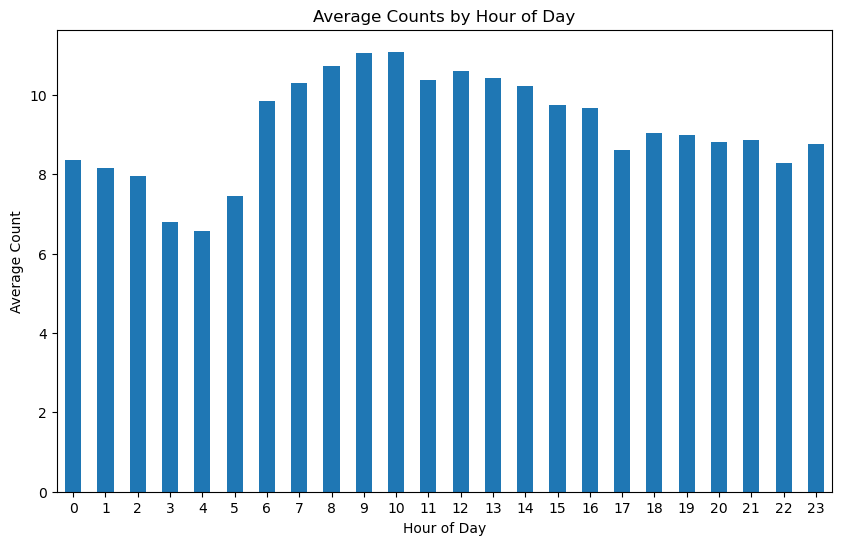

In [ ]:
# extract hour from datetime
df_filtered['hour'] = df_filtered['datetime'].dt.hour

# group by hour and compute average count
avg_counts_by_hour = df_filtered.groupby('hour')['events'].mean()

# plot
plt.figure(figsize=(10,6))
avg_counts_by_hour.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Average Counts by Hour of Day')
plt.xticks(rotation=0)
plt.show()

Generate daily footfall counts to align with weather data:

In [ ]:
# extract date (without time) from datetime
mobile_csv_convert['date'] = mobile_csv_convert['datetime'].dt.date

# group by date and id, then sum events
mobile_daily = (
    mobile_csv_convert
    .groupby(['date', 'id'])['events']
    .sum()
    .reset_index()
)

display(mobile_csv_convert)
display(mobile_daily.head())
len(mobile_daily)

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime,date
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00,2024-04-05
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00,2024-02-14
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00,2024-01-23
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00,2024-08-23
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00,2024-02-21
...,...,...,...,...,...,...,...,...,...
47207153,18929,U,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,1,2024-01-26 10:00:00,2024-01-26
47207154,48,S,United Kingdom,United Kingdom,10 - 15 km,00 - 01 km,2,2024-03-21 15:00:00,2024-03-21
47207155,2577,E,United Kingdom,United Kingdom,05 - 10 km,05 - 10 km,1,2024-06-06 11:00:00,2024-06-06
47207156,26004,K,United Kingdom,United Kingdom,01 - 05 km,50 km +,2,2024-07-07 14:00:00,2024-07-07


,date,id,events
0,2024-01-01,1,1714
1,2024-01-01,2,3148
2,2024-01-01,3,692
3,2024-01-01,4,27
4,2024-01-01,5,2164


1059996

Now that we have daily counts, we can add in temporal indicators based on the date.

Determine weekday/weekend season:

In [23]:
mobile_daily['date'] = pd.to_datetime(mobile_daily['date'])

# add weekend column (True if Saturday or Sunday)
mobile_daily['weekend'] = mobile_daily['date'].dt.dayofweek >= 5

# define a function to assign seasons (Northern Hemisphere, 2024)
def get_season(date):
    Y = date.year
    if pd.Timestamp(f'{Y}-03-20') <= date < pd.Timestamp(f'{Y}-06-20'):
        return 'Spring'
    elif pd.Timestamp(f'{Y}-06-20') <= date < pd.Timestamp(f'{Y}-09-22'):
        return 'Summer'
    elif pd.Timestamp(f'{Y}-09-22') <= date < pd.Timestamp(f'{Y}-12-21'):
        return 'Autumn'
    else:
        return 'Winter'

# add season column
mobile_daily['season'] = mobile_daily['date'].apply(get_season)

# display updated DataFrame
display(mobile_daily.head())

,date,id,events,weekend,season
0,2024-01-01,1,1714,False,Winter
1,2024-01-01,2,3148,False,Winter
2,2024-01-01,3,692,False,Winter
3,2024-01-01,4,27,False,Winter
4,2024-01-01,5,2164,False,Winter


Determine holidays:

In [24]:
# define UK bank holidays in 2024
uk_holidays_2024 = pd.to_datetime([
    '2024-01-01',  # New Year’s Day
    '2024-03-29',  # Good Friday
    '2024-04-01',  # Easter Monday
    '2024-05-06',  # Early May bank holiday
    '2024-05-27',  # Spring bank holiday
    '2024-08-26',  # Summer bank holiday
    '2024-12-25',  # Christmas Day
    '2024-12-26'   # Boxing Day
])

# add holiday column (True if the date is a holiday)
mobile_daily['holiday'] = mobile_daily['date'].isin(uk_holidays_2024)

# display updated df
display(mobile_daily.head())

,date,id,events,weekend,season,holiday
0,2024-01-01,1,1714,False,Winter,True
1,2024-01-01,2,3148,False,Winter,True
2,2024-01-01,3,692,False,Winter,True
3,2024-01-01,4,27,False,Winter,True
4,2024-01-01,5,2164,False,Winter,True


#### 1.1.5. Merging footfall with LocF data

At this stage we merge the footfall counts with location footprints.

First, integrate lookup table:

In [ ]:
# join locF id with mobile data based on lookup table 
mobile_locF = mobile_daily.merge(locF_lookup[['id', 'LocF_CentreID']], how='left', on='id')

Now we can merge:

In [ ]:
# join locF data with mobile data
mobile_locF = mobile_locF.merge(df_cleaned, how='inner', left_on='LocF_CentreID', right_on='Local_Footprint_Centre_ID')
mobile_locF = mobile_locF.drop(columns=['LocF_CentreID']) # drop redundant column

In [27]:
# check the number or rows matches the initial mobile data 
print(len(mobile_daily))
print(len(mobile_locF))

1059996
816193


In [28]:
# check cols
print(mobile_locF.columns)


Index(['date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local Footprint Name', 'Region', 'Base Score',
       'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Tourism Score', 'Local_Footprint_Centre_ID',
       'Local_Footprint_Centre_Name', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       '

In [29]:
# display all columns and their values for the first few rows
with pd.option_context('display.max_columns', None, 'display.width', None):
    display(mobile_locF.head())

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,Residential Population (Weighted Catchment),Spend Per Head (Residential),Sparsity,Longitude,Latitude,Tourism Score,Local_Footprint_Centre_ID,Local_Footprint_Centre_Name,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
0,2024-01-01,1,1714,False,Winter,True,London - Tooting,London,472,507,54173,1933.087727,5 - Urban Dense (London),-0.166467,51.428020,59.668318,01-0001-22,London - Tooting,453.0,254.0,684.0,0.0,T,T,T,T,T,T,T,T,T,T,T,T,F,T,4,Local High Street,401,Urban High Street,1,Not seasonal
1,2024-01-01,2,3148,False,Winter,True,London - East Ham,London,358,389,53781,1733.492583,5 - Urban Dense (London),0.054717,51.540270,25.178087,01-0002-22,London - East Ham,374.0,227.0,409.0,0.0,T,T,T,T,T,T,T,T,T,T,T,T,F,F,4,Local High Street,401,Urban High Street,1,Not seasonal
2,2024-01-01,3,692,False,Winter,True,London - Old Street,London,157,165,7862,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,715.736173,01-0003-22,London - Old Street,340.0,51.0,307.0,0.0,T,T,T,T,T,F,T,T,T,T,T,T,F,F,1,City Centre,110,Worker,1,Not seasonal
3,2024-01-01,5,2164,False,Winter,True,London - Shepherds Bush,London,398,423,13418,1972.601453,5 - Urban Dense (London),-0.227470,51.502096,160.154406,01-0005-22,London - Shepherds Bush,368.0,169.0,698.0,0.0,T,T,T,T,T,T,T,T,T,T,T,T,F,T,1,City Centre,103,Secondary Retail,1,Not seasonal
4,2024-01-01,6,1759,False,Winter,True,London - Peckham,London,314,339,22947,1885.443578,5 - Urban Dense (London),-0.069161,51.470036,118.639624,01-0006-22,London - Peckham,320.0,181.0,410.0,0.0,T,T,T,T,T,T,T,T,T,T,T,T,F,T,1,City Centre,103,Secondary Retail,1,Not seasonal


Check for NAs:

In [30]:
# print NA sums
display(mobile_locF.isna().sum())

date                                                         0
id                                                           0
events                                                       0
weekend                                                      0
season                                                       0
holiday                                                      0
Local Footprint Name                                         0
Region                                                       0
Base Score                                                   0
Retail Footprint Score                                       0
Residential Population (Weighted Catchment)                  0
Spend Per Head (Residential)                                 0
Sparsity                                                     0
Longitude                                                    0
Latitude                                                     0
Tourism Score                                          

NaNs are associated with Tourism Score, Major/Minor Class and Seasonality Class. Nothing of particular concern here. 

We can check which rows are missing values:

In [31]:
na_tourism = mobile_locF[mobile_locF['Tourism Score'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_tourism)

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,Residential Population (Weighted Catchment),Spend Per Head (Residential),Sparsity,Longitude,Latitude,Tourism Score,Local_Footprint_Centre_ID,Local_Footprint_Centre_Name,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
212,2024-01-01,1350,1348,False,Winter,True,London Heathrow Airport -,London,300,343,0,0.00000,5 - Urban Dense (London),-0.487946,51.471608,NaN,02-0153-22,London Heathrow Airport - Terminal 5,50.0,249.0,70.0,0.0,T,T,T,F,T,F,F,T,F,F,T,T,F,F,4,Local High Street,401,Urban High Street,1,Not seasonal
229,2024-01-01,1459,1447,False,Winter,True,London Heathrow Airport -,London,160,182,0,0.00000,5 - Urban Dense (London),-0.451302,51.470321,NaN,02-0262-22,London Heathrow Airport - Terminal 2,37.0,157.0,68.0,0.0,F,T,F,F,T,F,F,T,T,T,T,T,F,F,4,Local High Street,401,Urban High Street,1,Not seasonal
255,2024-01-01,1614,748,False,Winter,True,London Heathrow Airport -,London,189,215,0,0.00000,5 - Urban Dense (London),-0.458626,51.470903,NaN,02-0416-22,London Heathrow Airport - Terminal 3,20.0,97.0,44.0,0.0,T,T,F,F,T,F,F,T,T,F,T,T,F,F,4,Local High Street,401,Urban High Street,6,Winter months
502,2024-01-01,5834,101,False,Winter,True,Doncaster - Dome Leisure,Yorkshire and The Humber,29,29,0,0.00000,6 - Retail Park,-1.104043,53.514081,NaN,05-0125-22,Doncaster - Dome Leisure Park,13.0,0.0,99.0,0.0,T,F,F,F,F,F,T,T,F,F,F,T,F,F,3,Retail Park,304,Leisure Park,1,Not seasonal
529,2024-01-01,6156,32,False,Winter,True,Stocksbridge - Fox Valley,Yorkshire and The Humber,161,138,20252,2155.71929,2 - Small Urban,-1.586133,53.482745,NaN,05-0444-24,Stocksbridge - Fox Valley Shopping Park,26.0,103.0,35.0,0.0,T,T,F,T,T,F,F,T,T,F,T,T,F,T,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815644,2024-12-31,26099,54,False,Winter,False,Moto Wetherby Services,Yorkshire and The Humber,46,44,0,0.00000,3 - Urban,-1.368609,53.946891,NaN,37-0101-22,Moto Wetherby Services,13.0,4.0,26.0,0.0,T,T,F,F,F,F,T,T,F,F,T,T,F,F,7,Transient,701,Motorway,3,Summer Holidays
815709,2024-12-31,27386,23,False,Winter,False,Cherwell Valley Services,South East,53,47,0,0.00000,2 - Small Urban,-1.199487,51.949754,NaN,39-0129-22,Cherwell Valley Services,4.0,28.0,0.0,0.0,T,F,F,F,F,F,F,T,F,F,T,F,F,F,7,Transient,701,Motorway,3,Summer Holidays
815834,2024-12-31,29646,83,False,Winter,False,Cobham Services,South East,60,54,0,0.00000,2 - Small Urban,-0.405497,51.304657,NaN,44-0081-22,Cobham Services,17.0,7.0,55.0,0.0,T,T,F,F,F,F,T,T,F,F,T,T,F,F,7,Transient,701,Motorway,3,Summer Holidays
815856,2024-12-31,30277,20,False,Winter,False,Corley Services,West Midlands,23,22,0,0.00000,2 - Small Urban,-1.546500,52.471368,NaN,45-0067-22,Corley Services,21.0,7.0,35.0,0.0,T,F,F,F,F,F,T,T,F,F,T,T,F,F,7,Transient,701,Motorway,2,Warm months


In [32]:
na_class = mobile_locF[mobile_locF['Major_Class_Name'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_class)

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,Residential Population (Weighted Catchment),Spend Per Head (Residential),Sparsity,Longitude,Latitude,Tourism Score,Local_Footprint_Centre_ID,Local_Footprint_Centre_Name,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
90,2024-01-01,418,153,False,Winter,True,Hoxton - Murray Grove,London,157,165,7862,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,715.736173,01-0417-24,Hoxton - Murray Grove,20.0,0.0,16.0,0.0,T,T,T,F,T,F,F,T,T,F,F,T,F,F,0,NaN,0,NaN,0,NaN
116,2024-01-01,615,65,False,Winter,True,London - Bell Green,London,219,211,30897,1810.689108,6 - Retail Park,-0.034461,51.429477,71.370285,01-0610-24,London - Bell Green,9.0,94.0,9.0,0.0,T,F,F,F,F,F,F,T,T,F,T,T,F,T,0,NaN,0,NaN,0,NaN
147,2024-01-01,1074,75,False,Winter,True,Hoxton - New North Road,London,433,449,30181,1812.007827,5 - Urban Dense (London),-0.075624,51.528560,625.599497,01-1063-24,Hoxton - New North Road,2.0,0.0,3.0,0.0,T,F,F,T,F,F,F,F,F,F,F,T,F,F,0,NaN,0,NaN,0,NaN
148,2024-01-01,1076,22,False,Winter,True,Kensington - West Cromwel,London,153,162,3847,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,378.022527,01-1064-24,Kensington - West Cromwell Road,1.0,0.0,8.0,0.0,F,F,F,F,F,F,F,F,F,F,F,T,F,F,0,NaN,0,NaN,0,NaN
149,2024-01-01,1078,20,False,Winter,True,London - Kensington - Cro,London,153,162,3847,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,378.022527,01-1065-24,London - Kensington - Cromwell Road - 2,1.0,0.0,4.0,0.0,F,T,F,F,F,F,F,F,F,F,F,T,F,F,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814118,2024-12-31,1076,24,False,Winter,False,Kensington - West Cromwel,London,153,162,3847,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,378.022527,01-1064-24,Kensington - West Cromwell Road,1.0,0.0,8.0,0.0,F,F,F,F,F,F,F,F,F,F,F,T,F,F,0,NaN,0,NaN,0,NaN
814119,2024-12-31,1078,128,False,Winter,False,London - Kensington - Cro,London,153,162,3847,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,378.022527,01-1065-24,London - Kensington - Cromwell Road - 2,1.0,0.0,4.0,0.0,F,T,F,F,F,F,F,F,F,F,F,T,F,F,0,NaN,0,NaN,0,NaN
814512,2024-12-31,6156,188,False,Winter,False,Stocksbridge - Fox Valley,Yorkshire and The Humber,161,138,20252,2155.719290,2 - Small Urban,-1.586133,53.482745,NaN,05-0444-24,Stocksbridge - Fox Valley Shopping Park,26.0,103.0,35.0,0.0,T,T,F,T,T,F,F,T,T,F,T,T,F,T,0,NaN,0,NaN,0,NaN
814629,2024-12-31,7864,25,False,Winter,False,West Bromwich - Kings Squ,West Midlands,561,608,70740,1527.630413,4 - Urban Dense,-1.994132,52.518770,40.935058,07-0525-24,West Bromwich - Kings Square Shopping Centre - 2,7.0,14.0,17.0,0.0,T,T,F,F,T,F,F,F,F,F,T,T,F,F,0,NaN,0,NaN,0,NaN


Even though we have LocF data integrated, we still need to include the LocF boundaries. 

GeoData merge:

In [33]:
print(locF_gdf.columns)

Index(['Local_Foot', 'geometry'], dtype='object')


In [34]:
# get rows with duplicated Local_Foot values
duplicates = locF_gdf[locF_gdf['Local_Foot'].duplicated(keep=False)]
# sort so duplicate groups are adjacent
duplicates = duplicates.sort_values(by='Local_Foot')
# display info
print(f"Number of duplicate 'Local_Foot' values: {duplicates['Local_Foot'].nunique()}")
display(duplicates)

Number of duplicate 'Local_Foot' values: 90


,Local_Foot,geometry
142,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
75,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
79,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
231,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
69,01-0009-22,"POLYGON ((530260.754 175176.804, 530275.709 17..."
...,...,...
2430,63-0260-22,"POLYGON ((257066.733 666676.716, 257074.784 66..."
2688,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
654,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
2406,63-1089-22,"POLYGON ((257126.777 666905.639, 257127.748 66..."


We can see the geometry is identical, so let's get rid of duplicate occurences. 

In [35]:
locF_gdf = locF_gdf.drop_duplicates(subset='Local_Foot', keep='first')
len(locF_gdf)

2999

In [ ]:
# merge with gdf
mobile_locF_gdf= locF_gdf.merge(mobile_locF, left_on='Local_Foot', right_on='Local_Footprint_Centre_ID', how='left')
mobile_locF_gdf = mobile_locF_gdf.drop(columns=['Local_Foot'])

In [37]:
print(mobile_locF_gdf.columns)
print(len(mobile_daily))
print(len(mobile_locF_gdf))

Index(['geometry', 'date', 'id', 'events', 'weekend', 'season', 'holiday',
       'Local Footprint Name', 'Region', 'Base Score',
       'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Tourism Score', 'Local_Footprint_Centre_ID',
       'Local_Footprint_Centre_Name', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisur

In [38]:
print("Unique Major Classes:", mobile_locF_gdf['Major_Class_Name'].unique())
print("Unique Minor Classes:", mobile_locF_gdf['Minor_Class_Name'].unique())

Unique Major Classes: ['Standalone' 'City Centre' 'Retail Park' 'Transient' 'Local High Street'
 nan 'Local Parade' 'Retail Destination']
Unique Minor Classes: ['Residential' 'Convenience and Services' 'Leisure Park'
 'Secondary Retail' 'Major Retail' 'Station'
 'Specialist Eating and Drinking' nan 'Worker'
 'Mainstream Eating and Drinking' 'Convenience' 'Discount Retail'
 'Independent Bars Cafes and Restaurants' 'Strong Urban Parade'
 'Local Mall' 'Urban High Street' 'Pharmacy' 'Retail Park'
 'Late Night Entertainment' 'Premium Retail' 'Supermarket'
 'Major Urban Centre' 'Independent Retail' 'Outlet Centre'
 'Small Urban Parade' 'Regional Town' 'Catering' 'Shopping Park'
 'Railway and Underground Station' 'Petrol Station'
 'Small Takeaway and Catering' 'Local Town' 'Small Rural Centre'
 'Rural Centre' 'Local Rural Centre' 'Motorway' 'Bank or Building Society']


### 1.2. Retail Typology Data

At this point, all the CACI data has been integrated. Now, we can move on to assigining retail centre type classifications from the Geographic Data Service. 

#### 1.2.1. Loading in

In [ ]:
# load typology data
typology = gpd.read_file("Data/typology_2022.gpkg")
typology = typology.to_crs(epsg=27700)

In [ ]:
# check columns and group names
print(typology['supergroupName'].unique())
print(typology['groupName'].unique())

["Local 'everyday' goods and service centres" 'Retail and shopping parks'
 'Leading comparison and leisure destinations'
 'Traditional high streets and market towns']
['Local urban convenience centres' 'District urban service centres'
 'Secondary retail parks and shopping centres'
 'Large regional retail and leisure destinations'
 'Mass and value high streets' 'Indie high streets'
 'Sub-regional retail and leisure destinations'
 'Primary shopping centres and premium destinations']


Let's make sure the geometries make sense:

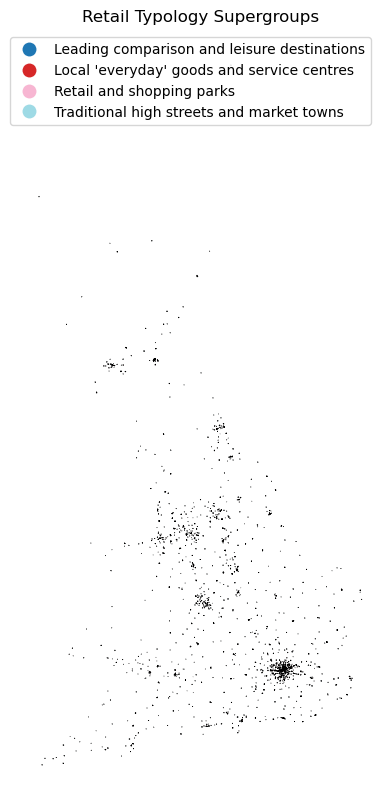

In [ ]:
# plot the typology GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
typology.plot(column="supergroupName", ax=ax, legend=True, cmap="tab20", edgecolor="black", linewidth=0.5)
ax.set_title("Retail Typology Supergroups")
ax.set_axis_off()
plt.show()

#### 1.2.2. Spatial intersection

An spatial intersection is used to merge retail classifications with our CACI boundaries.

To ensure we don't end up with any duplicates, we can sort the resulting geometries by area, and keep only IDs with the largest area if they are recurring:

In [42]:
# step 1: spatial intersection
intersected = gpd.overlay(mobile_locF_gdf, typology, how='intersection')

# step 2: add area column for filtering
intersected['area'] = intersected.geometry.area

# step 3: sort by area descending so largest is on top
intersected_sorted = intersected.sort_values('area', ascending=False)

# step 4: drop duplicates, keeping only the largest (first) for each ID
retail_areas = intersected_sorted.drop_duplicates(
    subset=['Local_Footprint_Centre_ID', 'date'], 
    keep='first'
)

# drop the temporary area column
retail_areas = retail_areas.drop(columns='area')

# drop rows where Local_Footprint_Centre_ID is NaN
retail_areas = retail_areas[retail_areas['Local_Footprint_Centre_ID'].notna()]

To be extra careful- we also remove rows without LocF IDs to guarantee we only work with rows that have CACI data:

In [ ]:
## remove rows where there is no Local_Footprint_Centre_ID
retail_areas = retail_areas[retail_areas['Local_Footprint_Centre_ID'].notna()]

In [ ]:
# check the number of unique LocF IDs
print(len(retail_areas['Local_Footprint_Centre_ID'].unique()))

2999
1207


In [ ]:
# check the first few rows of the final GeoDataFrame
display(retail_areas.head())

,date,id,events,weekend,season,holiday,Local Footprint Name,Region,Base Score,Retail Footprint Score,...,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name,RC_ID,RC_Name,supergroupID,supergroupName,groupID,groupName,geometry
369521,2024-10-11,17519.0,787.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,Shopping Park,1.0,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
369585,2024-12-14,17519.0,2128.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,Shopping Park,1.0,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
369578,2024-12-07,17519.0,1621.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,Shopping Park,1.0,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
369580,2024-12-09,17519.0,1471.0,False,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,Shopping Park,1.0,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
369579,2024-12-08,17519.0,1270.0,True,Autumn,False,Grays - West Thurrock,East of England,802.0,767.0,...,Shopping Park,1.0,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."


All done! 

Now let's write this out to a final gdf:

In [ ]:
# write the retail_areas GeoDataFrame to a GeoPackage
retail_areas.to_file("retail_areas.gpkg", layer="retail_areas", driver="GPKG")